# nnU-Net for BraTS21

# Table of contents
- [Introduction](#introduction)
- [Dataset](#dataset)
- [Data pre-processing](#preprocessing)
- [Data augmentations](#augmentations)
- [Loss function](#loss)
- [Model](#model)
- [Training](#training)
- [Inference](#inference)
- [Post-processing](#postprocessing)

# Introduction <a name="introduction"></a>

The goal of [BraTS 2021 challenge](https://www.med.upenn.edu/cbica/brats2021) was to create a model for segmenting the brain glioblastoma subregions in mpMRI scans. By using our nnU-Net implementation, NVIDIA data scientists have [won the BraTS21 validation phase](https://developer.nvidia.com/blog/nvidia-data-scientists-take-top-spots-in-miccai-2021-brain-tumor-segmentation-challenge). In this notebook, we will share with you the recipe we used for training our nnU-Net for BraTS21 challenge, so that you can reproduce our results. In particular, we will walk you through the following steps: data pre-processing, designing the loss function, building and training the model, running inference and finally post-processing the predictions.

# Dataset <a name="dataset"></a>

The training dataset provided for the BraTS21 challenge consists of 1,251 brain mpMRI scans along with segmentation annotations of tumorous regions. The 3D volumes were skull-stripped and resampled to 1 mm isotropic resolution, with dimensions of (240, 240, 155) voxels. For each example, four modalities were given: Fluid Attenuated Inversion Recovery (FLAIR), native (T1), post-contrast T1-weighted (T1Gd), and T2-weighted (T2). See image below with each modality. Annotations consist of four classes: 1 for necrotic tumor core (NCR), 2 for peritumoral edematous tissue (ED), 4 for enhancing tumor (ET), and 0 for background (voxels that are not part of the tumor).

To download the training and validation dataset, you need to have an account on https://www.synapse.org platform and be registered for BraTS21 challenge. We will assume that after downloading and unzipping, the dataset is organized as follows:

```
/data 
 │
 ├───BraTS2021_train
 │      ├──BraTS2021_00000 
 │      │      └──BraTS2021_00000_flair.nii.gz
 │      │      └──BraTS2021_00000_t1.nii.gz
 │      │      └──BraTS2021_00000_t1ce.nii.gz
 │      │      └──BraTS2021_00000_t2.nii.gz
 │      │      └──BraTS2021_00000_seg.nii.gz
 │      ├──BraTS2021_00002
 │      │      └──BraTS2021_00002_flair.nii.gz
 │      ...    └──...
 │
 └────BraTS2021_val
        ├──BraTS2021_00001 
        │      └──BraTS2021_00001_flair.nii.gz
        │      └──BraTS2021_00001_t1.nii.gz
        │      └──BraTS2021_00001_t1ce.nii.gz
        │      └──BraTS2021_00001_t2.nii.gz
        ├──BraTS2021_00002
        │      └──BraTS2021_00002_flair.nii.gz
        ...    └──...
```

Let's visualize a BraTS2021_00000 example from the training dataset. Each plot presents a different modality (from left to right: FLAIR, T1, T1ce, T2), and an annotation.

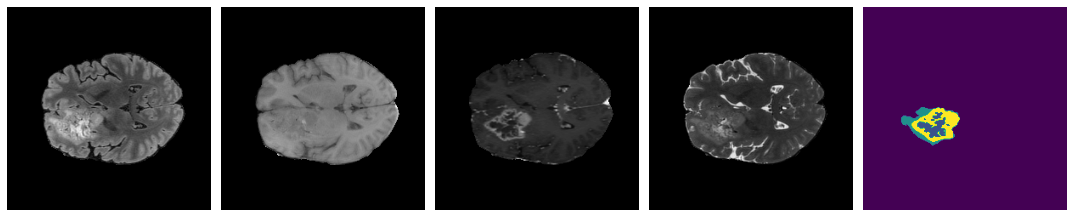

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
from glob import glob

imgs = [nib.load(f"/data/BraTS2021_train/BraTS2021_00000/BraTS2021_00000_{m}.nii.gz").get_fdata().astype(np.float32)[:, :, 75] for m in ["flair", "t1", "t1ce", "t2"]]
lbl = nib.load("/data/BraTS2021_train/BraTS2021_00000/BraTS2021_00000_seg.nii.gz").get_fdata().astype(np.uint8)[:, :, 75]
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(15, 15))
for i, img in enumerate(imgs):
    ax[i].imshow(img, cmap='gray')
    ax[i].axis('off')
ax[-1].imshow(lbl, vmin=0, vmax=4)
ax[-1].axis('off')
plt.tight_layout()            
plt.show()

# Data pre-processing <a name="preprocessing"></a>

Each example of the BraTS21 dataset consists of four [NIfTI](https://nifti.nimh.nih.gov/) files with different MRI modalities (filenames with suffixes flair, t1, t1ce, t2). Additionally, examples in the training dataset have a NIfTI with annotation (filename with suffix seg). As a first step of data pre-processing, all four modalities are stacked such that each example has shape (4, 240, 240, 155) (input tensor is in the (C, H, W, D) layout, where C-channels, H-height, W-width and D-depth). Then redundant background voxels (with voxel value zero) on the borders of each volume are [cropped](https://docs.monai.io/en/latest/transforms.html#cropforeground), as they do not provide any useful information and can be ignored by the neural network. Subsequently, for each example, the mean and the standard deviation are computed within the non-zero region for each channel separately. All volumes are [normalized](https://docs.monai.io/en/latest/transforms.html#normalizeintensityd) by first subtracting the mean and then divided by the standard deviation. The background voxels are not normalized so that their value remained at zero. To distinguish between background voxels and normalized voxels which have values close to zero, we add an input channel with one-hot encoding for foreground voxels and stacked with the input data. As a result, each example has 5 channels.

Let's start by preparing the raw training and validation datasets into stacked NIfTI files.

In [2]:
import json
import os
from glob import glob
from subprocess import call
import time

import nibabel
import numpy as np
from joblib import Parallel, delayed


def load_nifty(directory, example_id, suffix):
    return nibabel.load(os.path.join(directory, example_id + "_" + suffix + ".nii.gz"))


def load_channels(d, example_id):
    return [load_nifty(d, example_id, suffix) for suffix in ["flair", "t1", "t1ce", "t2"]]


def get_data(nifty, dtype="int16"):
    if dtype == "int16":
        data = np.abs(nifty.get_fdata().astype(np.int16))
        data[data == -32768] = 0
        return data
    return nifty.get_fdata().astype(np.uint8)


def prepare_nifty(d):
    example_id = d.split("/")[-1]
    flair, t1, t1ce, t2 = load_channels(d, example_id)
    affine, header = flair.affine, flair.header
    vol = np.stack([get_data(flair), get_data(t1), get_data(t1ce), get_data(t2)], axis=-1)
    vol = nibabel.nifti1.Nifti1Image(vol, affine, header=header)
    nibabel.save(vol, os.path.join(d, example_id + ".nii.gz"))

    if os.path.exists(os.path.join(d, example_id + "_seg.nii.gz")):
        seg = load_nifty(d, example_id, "seg")
        affine, header = seg.affine, seg.header
        vol = get_data(seg, "unit8")
        vol[vol == 4] = 3
        seg = nibabel.nifti1.Nifti1Image(vol, affine, header=header)
        nibabel.save(seg, os.path.join(d, example_id + "_seg.nii.gz"))


def prepare_dirs(data, train):
    img_path, lbl_path = os.path.join(data, "images"), os.path.join(data, "labels")
    call(f"mkdir {img_path}", shell=True)
    if train:
        call(f"mkdir {lbl_path}", shell=True)
    dirs = glob(os.path.join(data, "BraTS*"))
    for d in dirs:
        if "_" in d.split("/")[-1]:
            files = glob(os.path.join(d, "*.nii.gz"))
            for f in files:
                if "flair" in f or "t1" in f or "t1ce" in f or "t2" in f:
                    continue
                if "_seg" in f:
                    call(f"mv {f} {lbl_path}", shell=True)
                else:
                    call(f"mv {f} {img_path}", shell=True)
        call(f"rm -rf {d}", shell=True)


def prepare_dataset_json(data, train):
    images, labels = glob(os.path.join(data, "images", "*")), glob(os.path.join(data, "labels", "*"))
    images = sorted([img.replace(data + "/", "") for img in images])
    labels = sorted([lbl.replace(data + "/", "") for lbl in labels])

    modality = {"0": "FLAIR", "1": "T1", "2": "T1CE", "3": "T2"}
    labels_dict = {"0": "background", "1": "edema", "2": "non-enhancing tumor", "3": "enhancing tumour"}
    if train:
        key = "training"
        data_pairs = [{"image": img, "label": lbl} for (img, lbl) in zip(images, labels)]
    else:
        key = "test"
        data_pairs = [{"image": img} for img in images]

    dataset = {
        "labels": labels_dict,
        "modality": modality,
        key: data_pairs,
    }

    with open(os.path.join(data, "dataset.json"), "w") as outfile:
        json.dump(dataset, outfile)


def run_parallel(func, args):
    return Parallel(n_jobs=os.cpu_count())(delayed(func)(arg) for arg in args)


def prepare_dataset(data, train):
    print(f"Preparing BraTS21 dataset from: {data}")
    start = time.time()
    run_parallel(prepare_nifty, sorted(glob(os.path.join(data, "BraTS*"))))
    prepare_dirs(data, train)
    prepare_dataset_json(data, train)
    end = time.time()
    print(f"Preparing time: {(end - start):.2f}")

prepare_dataset("/data/BraTS2021_train", True)
prepare_dataset("/data/BraTS2021_val", False)
print("Finished!")

Preparing BraTS21 dataset from: /data/BraTS2021_train
Preparing time: 259.65
Preparing BraTS21 dataset from: /data/BraTS2021_val
Preparing time: 38.62
Finished!


Now, lets preprocesses the datasets by cropping and normalizing the volumes. We will store the pre-processed volumes as NumPy arrays.

In [3]:
!python3 ../preprocess.py --task 11 --ohe --exec_mode training
!python3 ../preprocess.py --task 12 --ohe --exec_mode test
print("Finished!")

Preprocessing /data/BraTS2021_train
Pre-processing time: 408.09
Preprocessing /data/BraTS2021_val
Pre-processing time: 68.28
Finished!


# Data Augmentations <a name="augmentations"></a>

Data augmentation is a technique that alleviates the overfitting problem by artificially extending a dataset during the training phase. To make our method more robust, the following data augmentations are used during training phase:

1. **Biased crop**: From the input volume, a patch of dimensions (5, 128, 128, 128) was randomly cropped. Additionally, with probability of 0.4 the patch selected via random biased crop is guaranteed that some foreground voxels (with positive class in the ground truth) are present in the cropped region.
2. **Zoom**: With probability of 0.15, a zoom factor is sampled uniformly from (1.0, 1.4) and then input volume is zoomed by a sampled factor with cubic interpolation, while label with nearest neighbor interpolation.
3. **Flips**: With probability of 0.5, for each x, y, z axis independently, volume was flipped along that axis.
4. **Gaussian Noise**: With probability of 0.15, random Gaussian noise with mean zero and standard deviation sampled uniformly from (0, 0.33) is sampled for each voxel and added to the input volume. 
5. **Gaussian Blur**: With probability of 0.15, Gaussian blurring with standard deviation of the Gaussian Kernel sampled uniformly from (0.5, 1.5) is applied to the input volume.
6. **Brightness**: With probability of 0.15, a random value is sampled uniformly from (0.7, 1.3) and then input volume voxels are multiplied by it.
7. **Contrast**: With probability of 0.15, a random value is sampled uniformly from (0.65, 1.5) and then input volume voxels are multiplied by it and clipped to its original min and max values.

The data loading pipeline is implemented with [NVIDIA Data Loading Library (DALI)](https://docs.nvidia.com/deeplearning/dali/user-guide/docs/index.html), which addresses the problem of the CPU bottleneck by offloading data augmentations to the GPU. We encourage you to check out the implementation details of our [DALI pipeline](https://github.com/NVIDIA/DeepLearningExamples/blob/master/PyTorch/Segmentation/nnUNet/data_loading/dali_loader.py).

# Loss function <a name="loss"></a>

The BraTS leaderboard is computed based on three partially overlapping regions: whole tumor (1, 2, 4), tumor core (1, 4) and enhancing tumor (4), instead of classes present in the labels. Thus, it is beneficial to construct the loss function based on classes used for ranking calculation. Therefore, we optimize each region separately with a sum of binary Cross-Entropy with the Dice loss.

In [4]:
import torch.nn as nn
from monai.losses import DiceLoss

class Loss(nn.Module):
    def __init__(self):
        super(Loss, self).__init__()
        self.dice = DiceLoss(sigmoid=True, batch=True)
        self.ce = nn.BCEWithLogitsLoss()

    def _loss(self, p, y):
        return self.dice(p, y) + self.ce(p, y.float())

    def forward(self, p, y):
        y_wt, y_tc, y_et = y > 0, ((y == 1) + (y == 3)) > 0, y == 3
        p_wt, p_tc, p_et = p[:, 0].unsqueeze(1), p[:, 1].unsqueeze(1), p[:, 2].unsqueeze(1)
        l_wt, l_tc, l_et = self._loss(p_wt, y_wt), self._loss(p_tc, y_tc), self._loss(p_et, y_et)
        return l_wt + l_tc + l_et

# Model <a name="model"></a>

We have made some modifications to the U-Net architecture for the BraTS challenge with respect to the original nnU-Net template. In particular, the U-Net template in the nnU-Net has the encoder depth of 6, and the convolution channels at each encoder level are: 32, 64, 128, 256, 320, 320. Based on the experiments we run, increasing the depth of the encoder to 7, modifying the number of channels to: 64, 96, 128, 192, 256, 384, 512, and using deep supervision improves the final score.

For deep supervision, we used two additional output heads at the decoder levels with feature map sizes (64, 64, 64) and (32, 32, 32). To match the shape of the additional predictions with the label shape of (128, 128, 128) we downsampled the label using the nearest neighbor interpolation to the (64, 64, 64) and (32, 32, 32) shapes, so that loss can be computed for additional outputs.

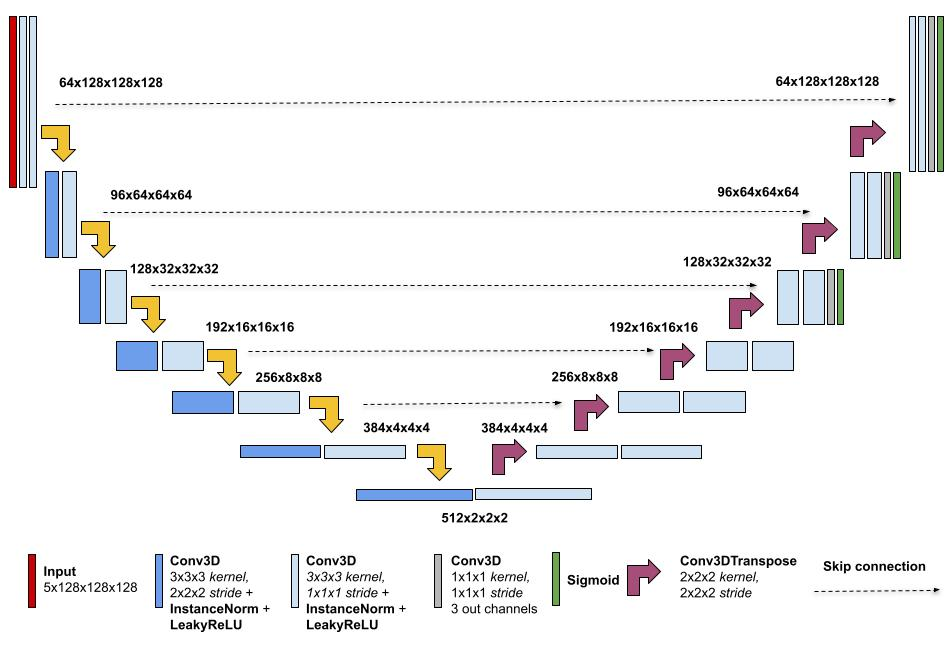

In [5]:
from IPython.display import Image
Image(filename="../images/unet-brats.jpg")

Figure 1: *The final U-Net architecture used for BraTS21 challenge.*

# Training <a name="training"></a>

Now, let's start training the model. For that, we will call the training script from our nnUNet repo with some additional command line arguments for BraTS challenge: 

- `--brats` - use loss function with partially overlapping regions (WT, TC, ET) and BraTS specific inference;
- `--deep_supervision` - use deep supervision loss with two additional output heads;
- `--more_chn` - create encoder with more channels than regular U-Net;
- `--min_fmap 2` - create deeper encoder, with feature map size in the bottleneck 2x2x2;

and the regular command line arguments:

- `--scheduler` - use cosine decay learning rate scheduler with warm up 250 steps of warm up;
- `--learning_rate 0.0003` - initial learning rate after warm up will be set to 0.0003;
- `--epochs 30` - training will be done for 30 epochs;
- `--fold 0` - training will be done for fold 0 (by default, 5-fold cross validation is used);
- `--amp` - training with automatic mixed precision, for faster training and memory reduction;
- `--gpus 1` - one GPU will be used during training;
- `--task 11` - task number for BraTS21 training dataset. See file `data_preprocessing/configs.py` for more details;
- `--save_ckpt` - save checkpoint with highest dice score acheived during training.

We will run training on 1xA100 GPU. To train the model with [AMP](https://developer.nvidia.com/automatic-mixed-precision), you will need a GPU with at least 15G memory.

Here, we will train the model on just 1-fold (fold with index 0) and 30 epochs. For the challenge submission, we have trained 5 models on each fold for 150 epochs, and averaged their predictions.

In [6]:
!python ../main.py --brats --deep_supervision --depth 6 --filters 64 96 128 192 256 384 512 --min_fmap 2 --scheduler --learning_rate 0.0003 --epochs 30 --fold 0 --amp --gpus 1 --task 11 --save_ckpt

Global seed set to 1
Number of examples: Train 1000 - Val 251
Filters: [64, 96, 128, 192, 256, 384, 512],
Kernels: [[3, 3, 3], [3, 3, 3], [3, 3, 3], [3, 3, 3], [3, 3, 3], [3, 3, 3], [3, 3, 3]]
Strides: [[1, 1, 1], [2, 2, 2], [2, 2, 2], [2, 2, 2], [2, 2, 2], [2, 2, 2], [2, 2, 2]]
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type      | Params
------------------------------------
0 | model | UNet      | 50.8 M
1 | loss  | LossBraTS | 0     
2 | dice  | Dice      | 0     
------------------------------------
50.8 M    Trainable params
0         Non-trainable params
50.8 M    Total params
203.356   Total estimated model params size (MB)
Epoch 0: 100%|█████████████████████████████████████████████████████████████████████████████████████████▉| 751/751 [02:53<00:00]
DLL 2021-10-07 09:47:10.369319 - Epoch: 0  Mean dice : 76.92  Highest : 76.92  L1 : 72.81  L2 : 72.71  L3 : 85.23  val

# Inference <a name="inference"></a>

During inference, the input volume can have arbitrary size, instead of the fixed patch size (128, 128, 128) as during the training phase. Thus, we use a [sliding window inference](https://docs.monai.io/en/latest/inferers.html) from [MONAI](https://monai.io/) library, where the window has the same size as the training patch, i.e., (128, 128, 128) and adjacent windows overlap by half the size of a patch. The predictions on the overlapping regions are then averaged with Gaussian importance weighting, such that the weights of the center voxels have higher importance.

One of the known tricks to improve predictions robustness is to apply test time augmentations (TTA). During inference, we are creating eight versions of the input volume, such that each version corresponds to one of eight possible flips along the x, y, z axis combination. Then we run inference for each version of the input volume and transform the predictions back to the original input volume orientation by applying the same flips to predictions as was used for the input volume. Finally, the probabilities from all predictions were averaged.

Let's run inference with TTA on the challenge validation dataset.

Note: You will have to modify the `--ckpt_path` argument, such that the path to checkpoint is valid.

In [7]:
!python ../main.py --gpus 1 --amp --save_preds --exec_mode predict --brats --data /data/12_3d/test --ckpt_path /results/checkpoints/epoch=29-dice_mean=89.69.ckpt --tta

Global seed set to 1
Number of test examples: 219
Filters: [64, 96, 128, 192, 256, 384, 512],
Kernels: [[3, 3, 3], [3, 3, 3], [3, 3, 3], [3, 3, 3], [3, 3, 3], [3, 3, 3], [3, 3, 3]]
Strides: [[1, 1, 1], [2, 2, 2], [2, 2, 2], [2, 2, 2], [2, 2, 2], [2, 2, 2], [2, 2, 2]]
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Testing: 100%|███████████████████████████████████████████████████████████████████████████████████| 219/219 [10:39<00:00]


# Post-processing <a name="postprocessing"></a>

By optimizing the three overlapping regions (ET, TC, WT) we need to convert them back to the original classes (NCR, ED, ET). The strategy for transforming classes back to the original one is the following: if the WT probability for a given voxel is less than 0.45 then its class is set to 0 (background), otherwise if the probability for TC is less than 0.4 the voxel class is 2 (ED), and finally if probability for ET is less than 0.4 voxel has class 1 (NCR), or otherwise 4 (ET).

Furthermore, we applied the following post-processing strategy: find ET connected components, for components smaller than 16 voxels with mean probability smaller than 0.9, replace their class to NCR (such that voxels are still considered part of the tumor core), next if there is overall less than 73 voxels with ET and their mean probability is smaller than 0.9 replace all ET voxels to NCR. With such post-processing we avoided the edge case where the model predicted a few voxels with enhancing tumor (ET) but there were not any in the ground truth. Such post-processing was beneficial to the final score as if there were no enhancing tumor voxels in the label, then the Dice score for zero false positive prediction was 1, and 0 otherwise.

In [8]:
import os
from glob import glob
from subprocess import call

import nibabel as nib
import numpy as np
from scipy.ndimage.measurements import label


def to_lbl(pred):
    enh = pred[2]
    c1, c2, c3 = pred[0] > 0.5, pred[1] > 0.5, pred[2] > 0.5
    pred = (c1 > 0).astype(np.uint8)
    pred[(c2 == False) * (c1 == True)] = 2
    pred[(c3 == True) * (c1 == True)] = 4

    components, n = label(pred == 4)
    for et_idx in range(1, n + 1):
        _, counts = np.unique(pred[components == et_idx], return_counts=True)
        if 1 < counts[0] and counts[0] < 8 and np.mean(enh[components == et_idx]) < 0.9:
            pred[components == et_idx] = 1

    et = pred == 4
    if 0 < et.sum() and et.sum() < 73 and np.mean(enh[et]) < 0.9:
        pred[et] = 1

    pred = np.transpose(pred, (2, 1, 0)).astype(np.uint8)
    return pred


def prepare_preditions(e):
    fname = e[0].split("/")[-1].split(".")[0]
    preds = [np.load(f) for f in e]
    p = to_lbl(np.mean(preds, 0))

    img = nib.load(f"/data/BraTS2021_val/images/{fname}.nii.gz")
    nib.save(
        nib.Nifti1Image(p, img.affine, header=img.header),
        os.path.join("/results/final_preds", fname + ".nii.gz"),
    )

os.makedirs("/results/final_preds")
preds = sorted(glob(f"/results/predictions*"))
examples = list(zip(*[sorted(glob(f"{p}/*.npy")) for p in preds]))
print("Preparing final predictions")
for e in examples:
    prepare_preditions(e)
print("Finished!")

Preparing final predictions
Finished!


# Visualization

Let's visualize the final prediction made on the challenge validation dataset.

BraTS2021_00001


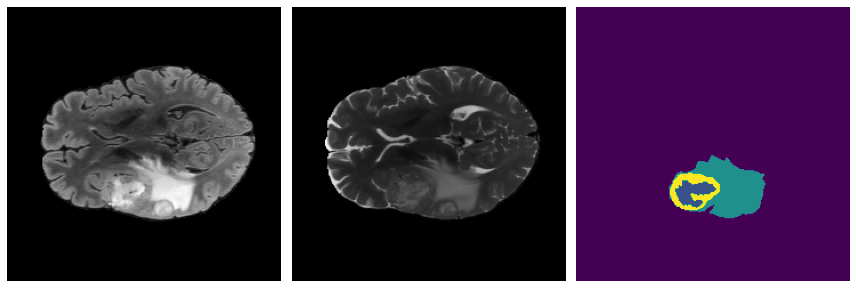

BraTS2021_00013


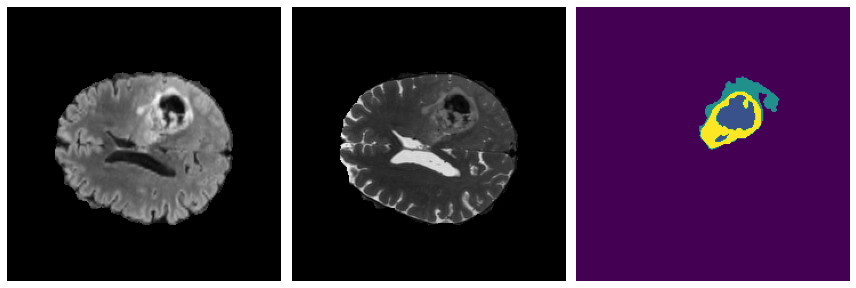

BraTS2021_00015


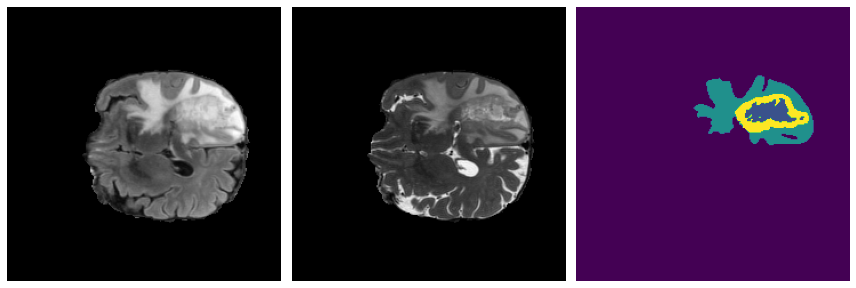

BraTS2021_00027


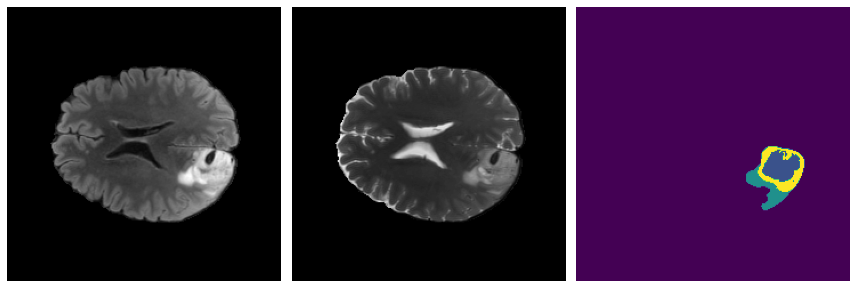

BraTS2021_00037


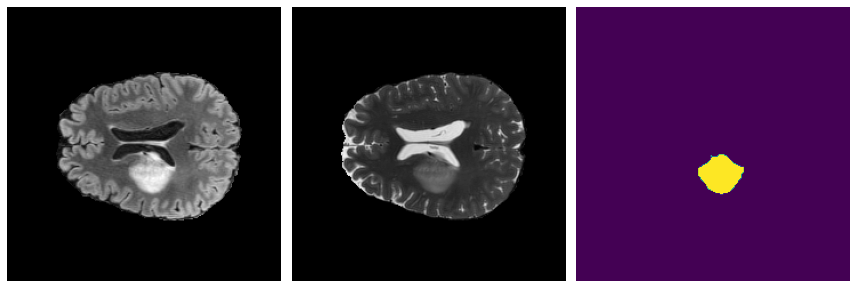

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
from glob import glob

n, z = 5, 75
data = sorted(glob("/results/final_preds/*.nii.gz"))
for i in range(n):
    fname = data[i].split("/")[-1].split(".")[0]
    print(fname)
    img = nib.load(f"/data/BraTS2021_val/images/{fname}.nii.gz").get_fdata().astype(np.float32)
    pred = nib.load(data[i]).get_fdata().astype(np.uint8)[:, :, z]
    imgs = [img[:, :, z, i] for i in [0, 3]] + [pred]
    
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 12))
    for i in range(3):
        if i < 2:
            ax[i].imshow(imgs[i], cmap='gray')
        else:
            ax[i].imshow(imgs[i]);
        ax[i].axis('off')  
    plt.tight_layout()            
    plt.show()